In [4]:
# Import relevant libraries

%load_ext autoreload
%autoreload 2
from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.persistence import RailEnvPersister
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import SparseRailGen
# from flatland_cutils import TreeObsForRailEnv as TreeCutils
from flatland.envs.observations import GlobalObsForRailEnv

from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.distance_map import DistanceMap
import flatland.envs.rail_env_shortest_paths as sp

from flatland.utils.rendertools import RenderTool

import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [ ]:
!pip install flatland-rl

In [5]:
# Create the environment

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, # Only one agent
    obs_builder_object=GlobalObsForRailEnv(),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

c:\Users\Emile\anaconda3\envs\Default\Lib\site-packages\flatland\utils\rendertools.py:397: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  warnings.warn(


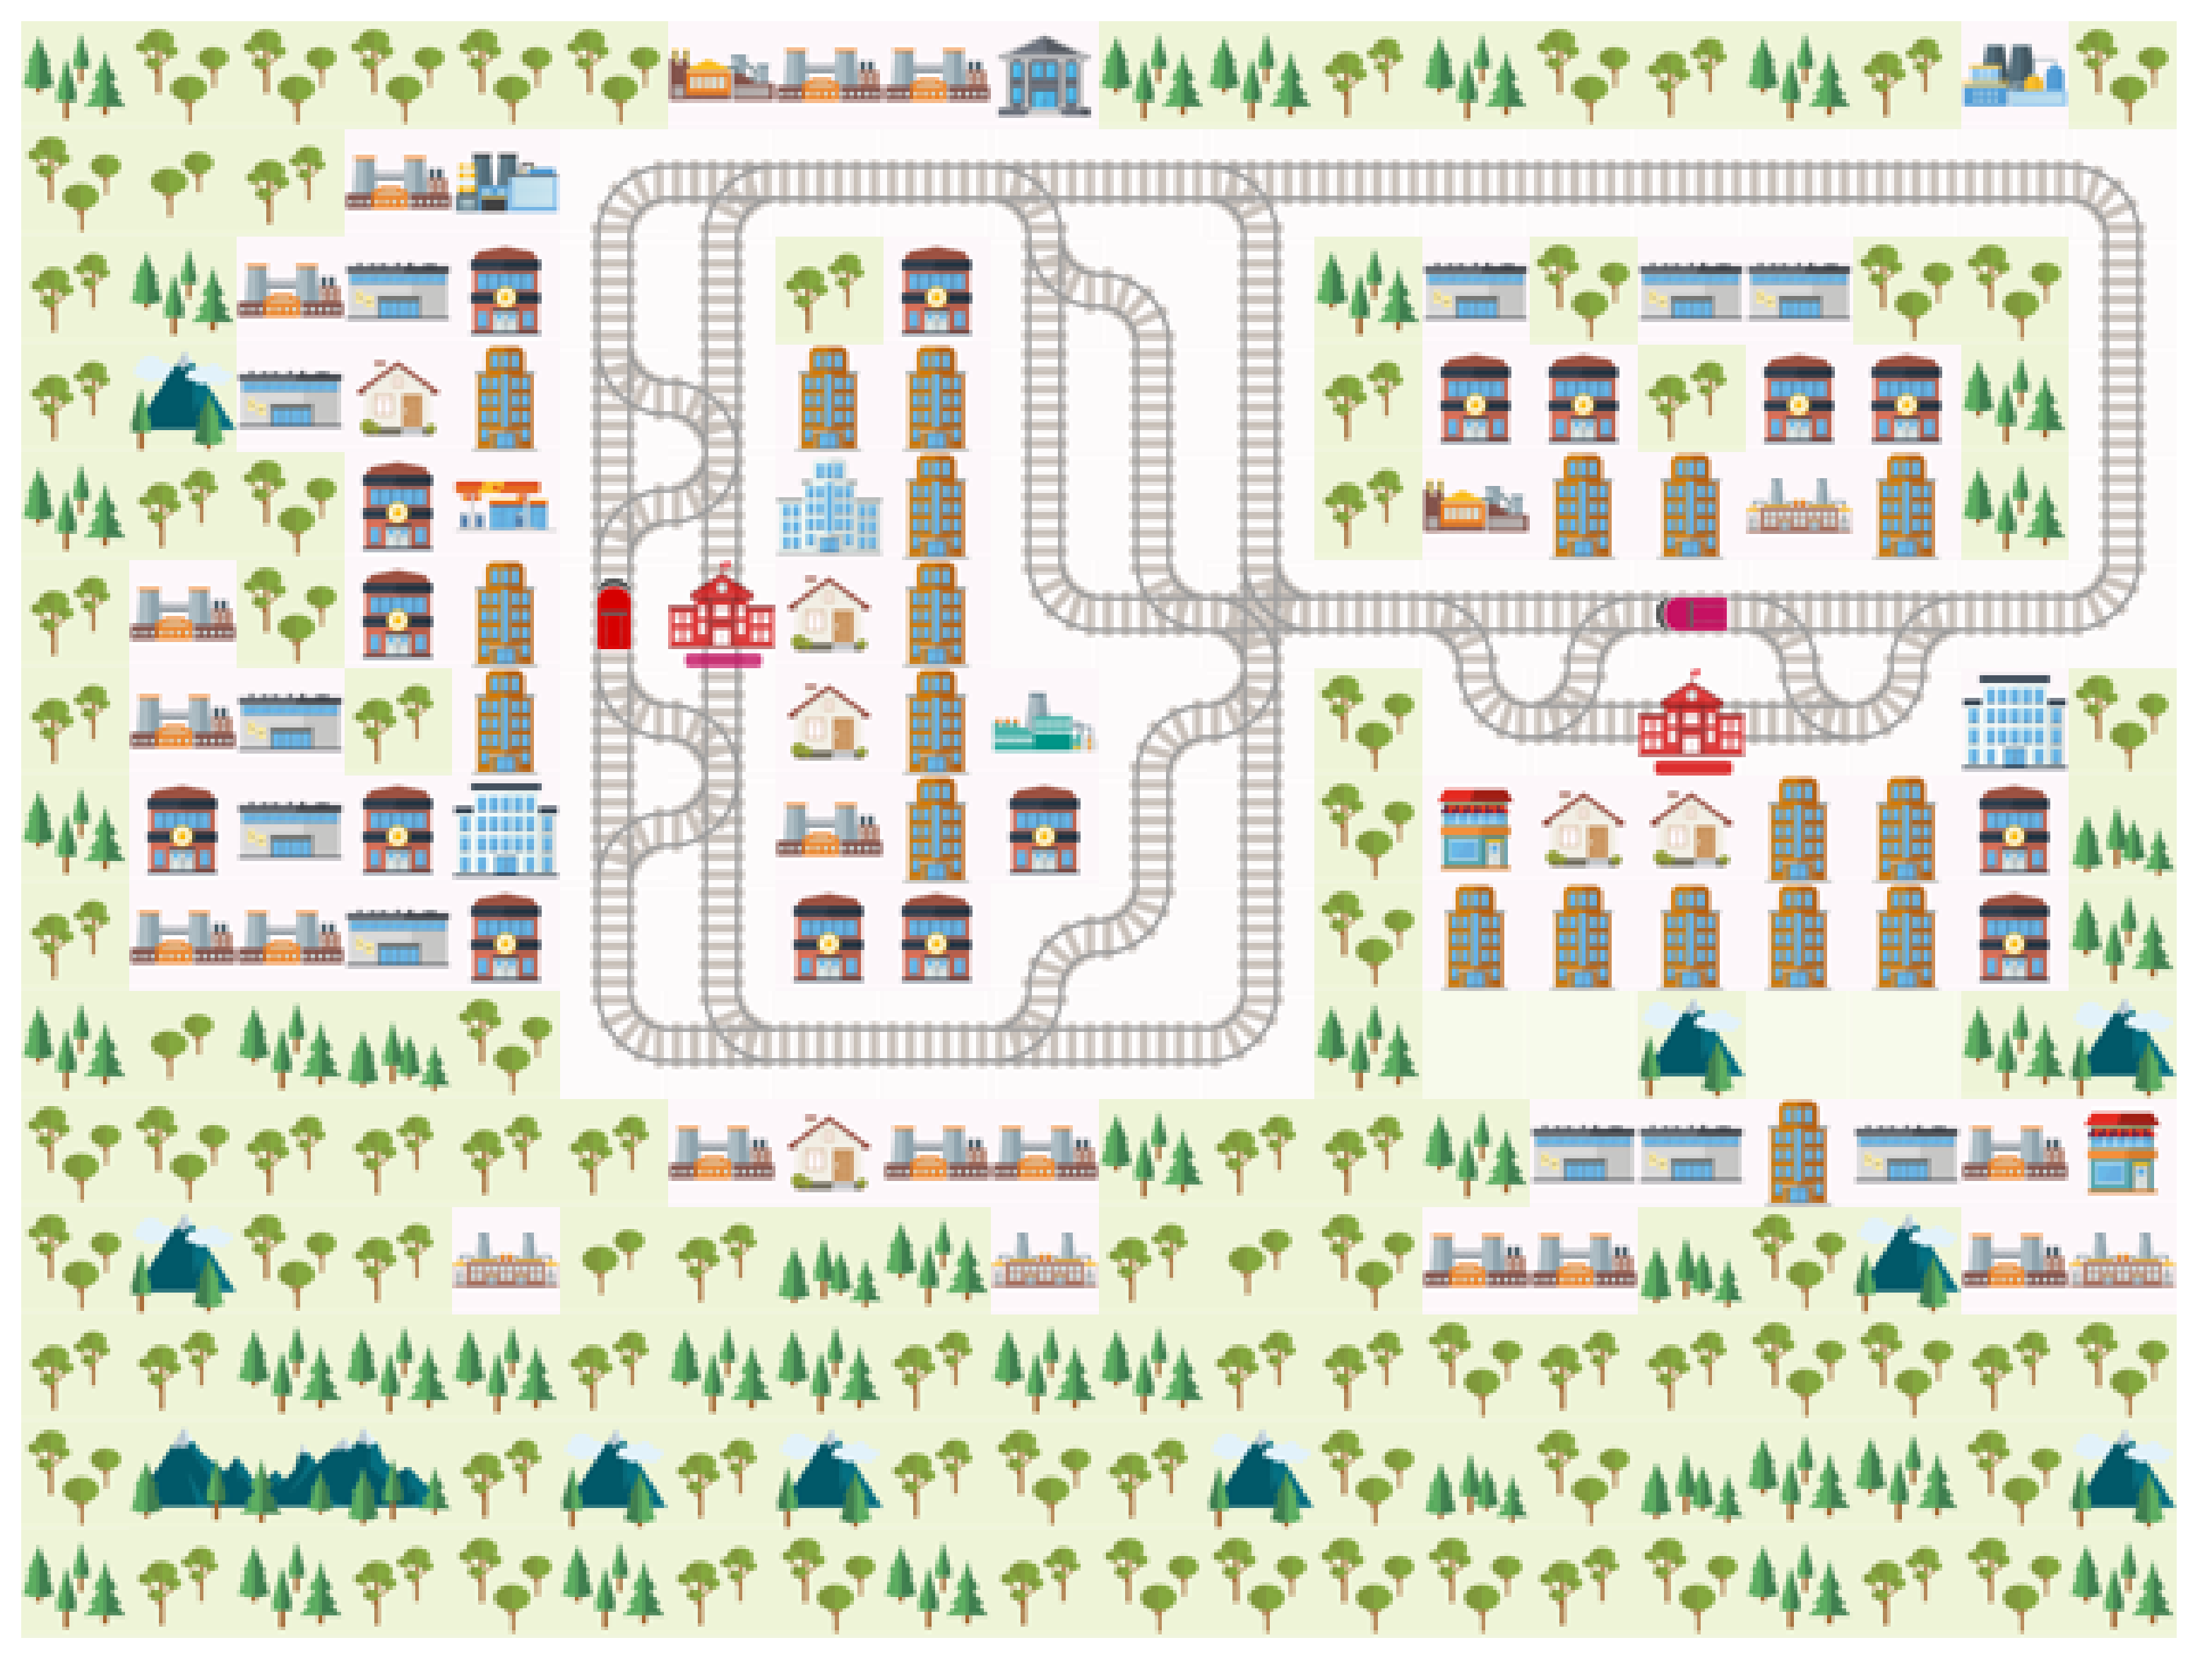

In [6]:
# First basic rendering with inactive agents

env.reset()
env_renderer = RenderTool(env)
image = env_renderer.render_env(return_image=True, show_inactive_agents=True)

plt.figure(figsize=(20, 10), dpi=300)
plt.axis('off')
plt.imshow(image)
plt.show()

In [7]:
# Display information on the environment (agents and their timetable, start position, etc)
for a in env.agents:
    print("Initial agent position: ", a.initial_position)
    print("Initial agent direction: ", a.initial_direction)
    print("Initial agent target: ", a.target)
    # ...

Initial agent position:  (5, 5)
Initial agent direction:  0
Initial agent target:  (6, 15)
Initial agent position:  (5, 15)
Initial agent direction:  3
Initial agent target:  (5, 6)


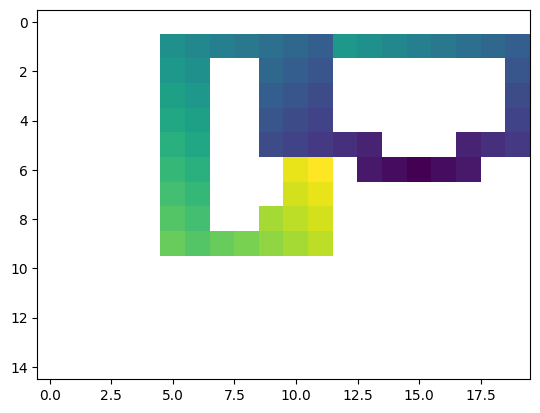

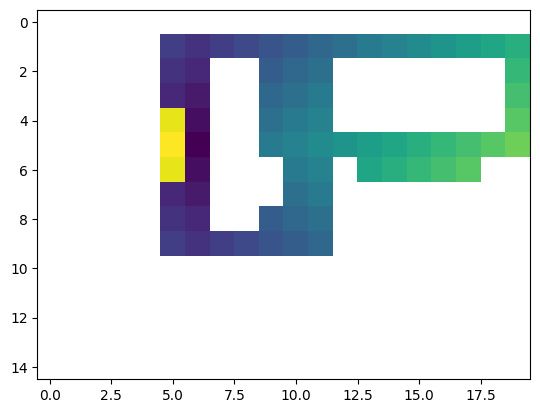

{0: 2, 1: 2}


In [8]:
env.reset()

def get_shortest_paths(env, vis=False):
    distance_map = DistanceMap(env.agents, env.width, env.height)
    distance_map.reset(env.agents, env.rail)
    distance_map.get()

    # Visualize the distance map
    if vis:
        sp.visualize_distance_map(distance_map, 0)
        sp.visualize_distance_map(distance_map, 1)

    shortest_paths = sp.get_shortest_paths(distance_map)
    for handle in shortest_paths.keys():
        if len(shortest_paths) <= 1:
            shortest_paths[handle] = 2
        elif env.agents[handle].position is None:
            shortest_paths[handle] = 2 # Forward = start moving in the map
        else:
            next_cell = shortest_paths[handle][1] # Next cell to visit
            shortest_paths[handle] = sp.get_action_for_move(env.agents[handle].position, 
                                                        env.agents[handle].direction,
                                                        next_cell.position,
                                                        next_cell.direction,
                                                        env.rail)
    return shortest_paths

# Test the shortest path function
actions = get_shortest_paths(env, vis=True)
print(actions)

Initial agent position:  (26, 29)
Initial agent direction:  1
Initial agent target:  (7, 26)
Step 0
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 1
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 2
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 3
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 4
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 5
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 6
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 7
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 8
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 9
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}

                  handle(agent index): 0 
                  initial_position: (26, 29)  
                  init

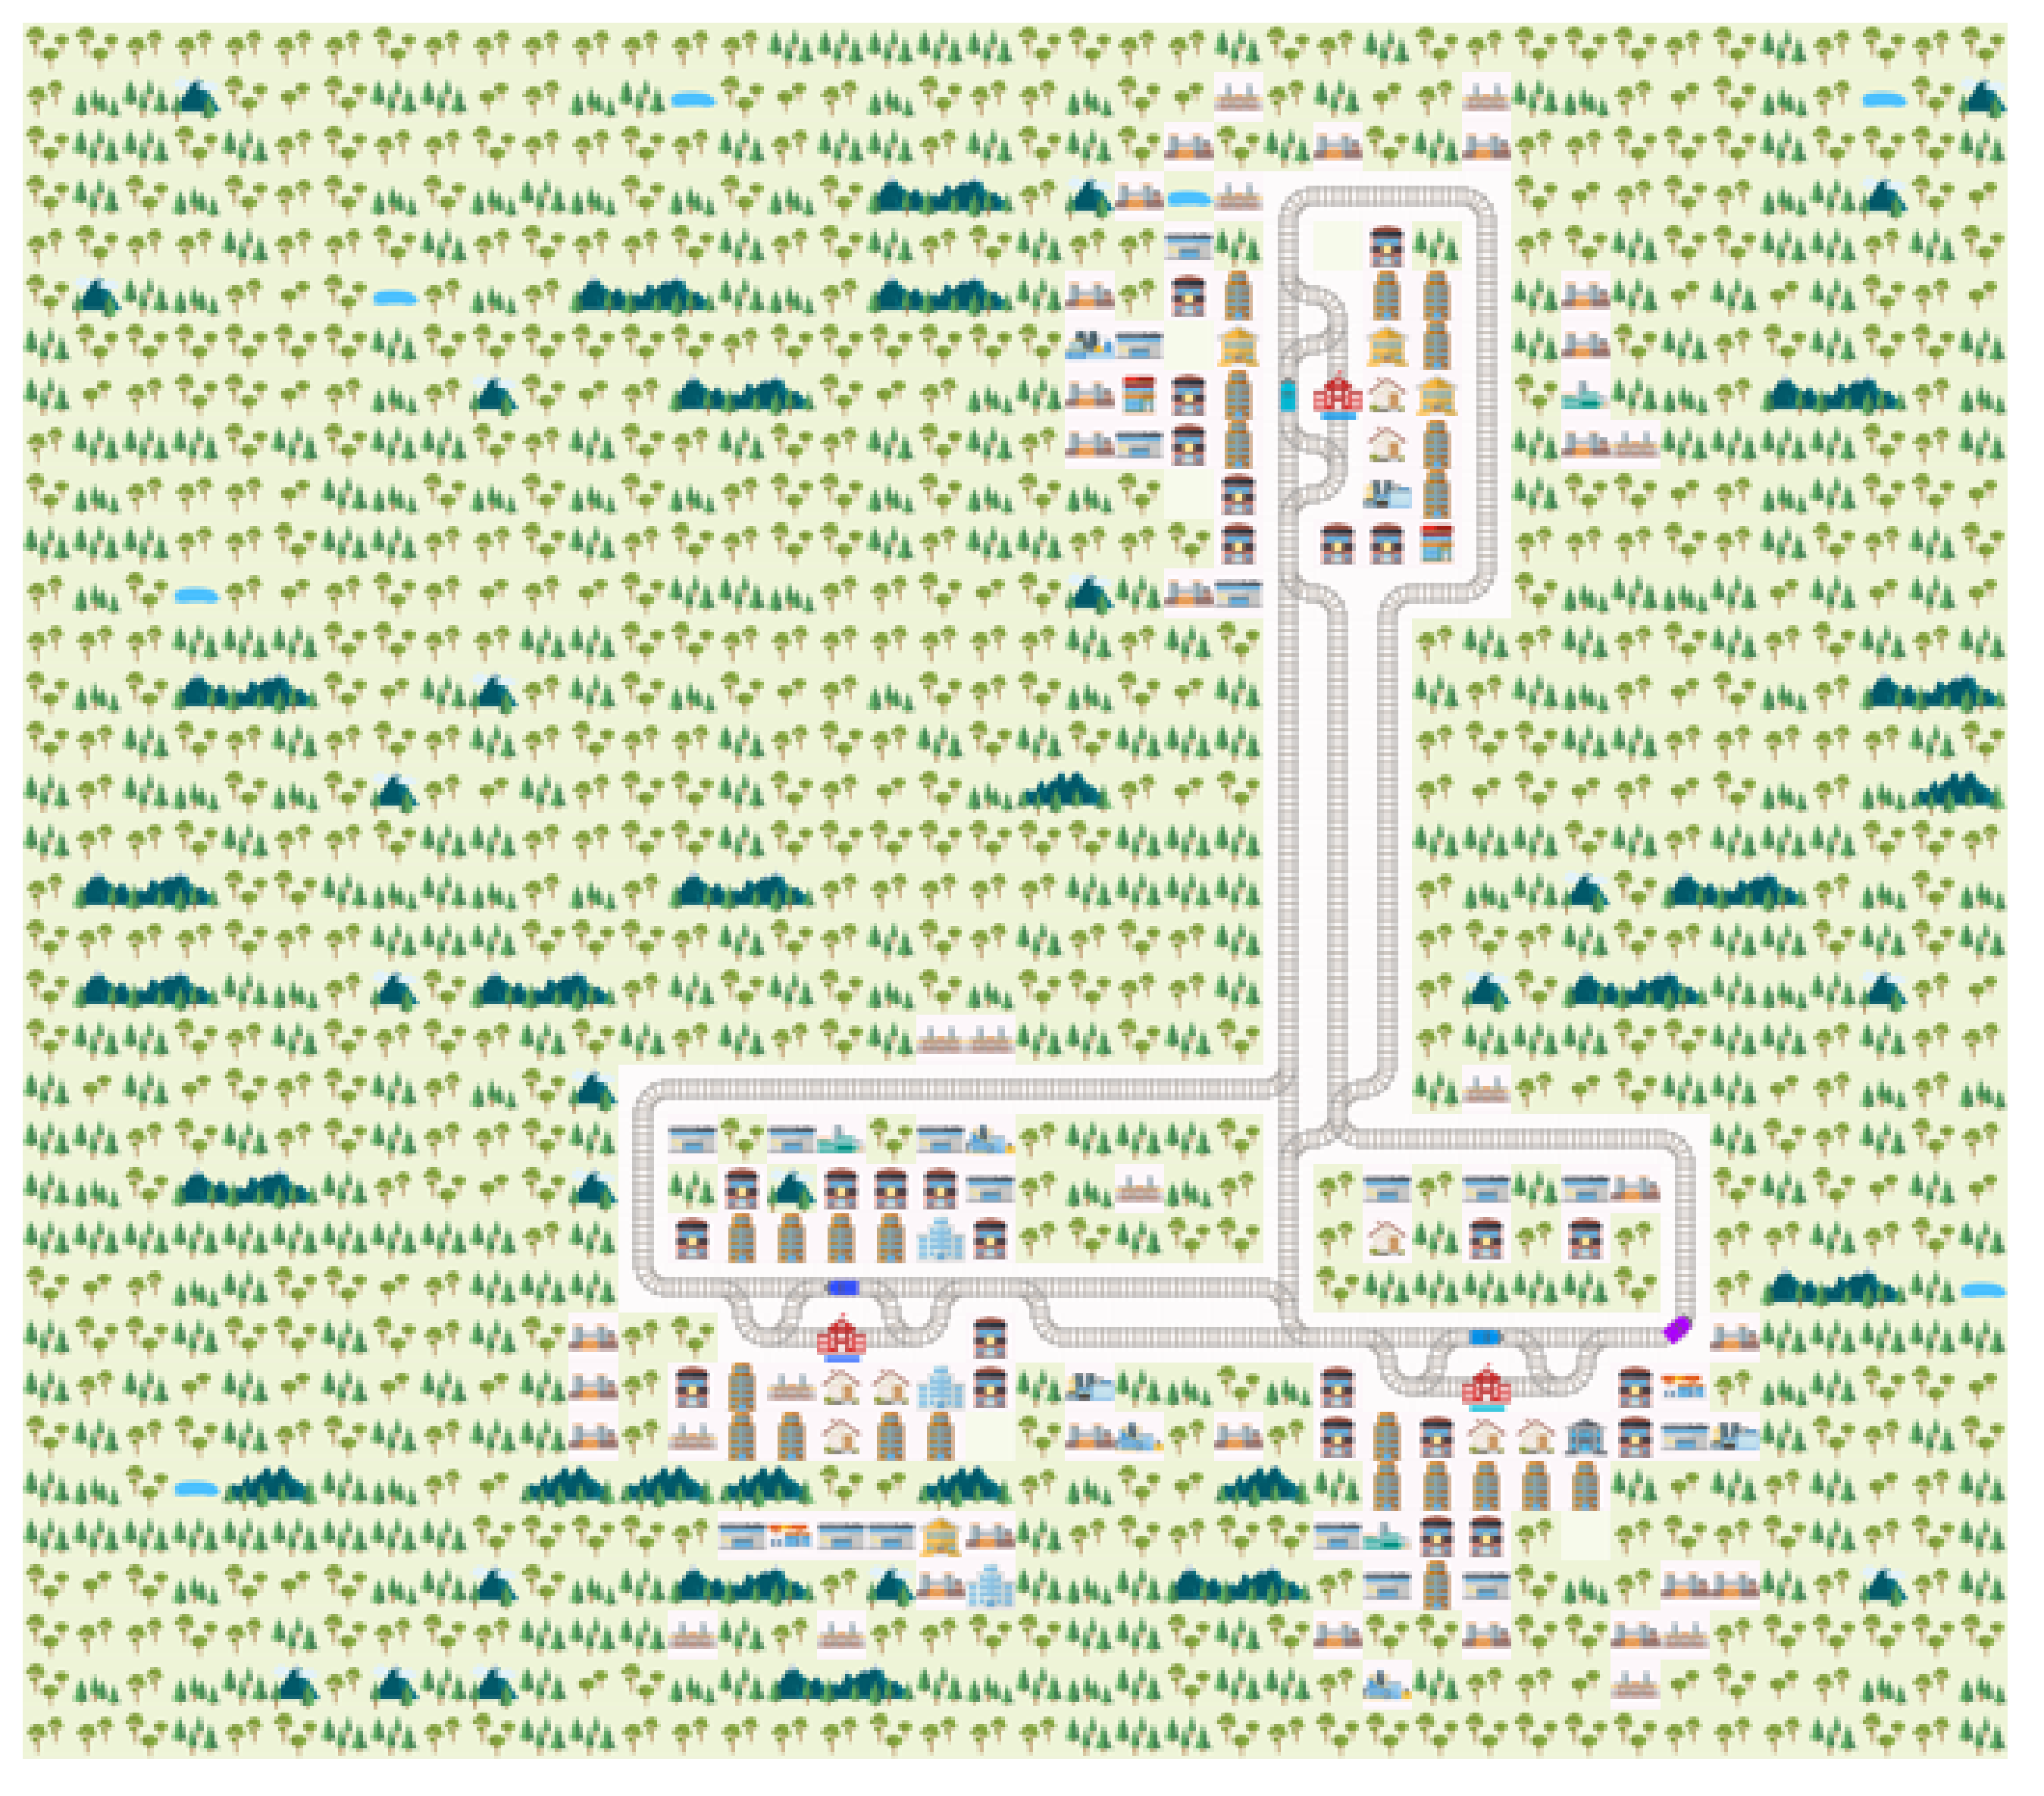

In [9]:
class SingleAgentShortest(TreeObsForRailEnv):
    '''Implements shortest path observation for the agents.'''
    def __init__(self):
        super().__init__(max_depth=0)

    def reset(self):
        super().reset()

    def get(self, handle):
        return get_shortest_paths(self.env)[handle]

# Create the environment
env = RailEnv(
    width=40,
    height=35,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=3,  # Number of cities
        grid_mode=False,
        max_rails_between_cities=1,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.},
        seed=0,  # Random seed
        ),
    number_of_agents=8,
    obs_builder_object=SingleAgentShortest(),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

obs, info = env.reset()
# Print initial position for agent 0
a = env.agents[0]
print("Initial agent position: ", a.initial_position)
print("Initial agent direction: ", a.initial_direction)
print("Initial agent target: ", a.target)

# Step loop
for step in range(10):
    actions = {}
    for handle in env.get_agent_handles():
        actions[handle] = obs[handle]
    print("Step", step)
    print("Actions", actions)
    obs, all_rewards, done, _ = env.step(actions)

# Agent's info for agent 0
print(a)
print(obs[a.handle])

# Render the final environment
env_renderer = RenderTool(env)
image = env_renderer.render_env(return_image=True, show_inactive_agents=True)
plt.figure(figsize=(20, 10), dpi=300)
plt.axis('off')
plt.imshow(image)
plt.show()

In [10]:
# Step loop with video rendering, shortest path policy

obs, info = env.reset()
env_renderer = RenderTool(env)
env_renderer.render_env(show=True, frames=True)

while True:
    actions = {}
    for handle in env.get_agent_handles():
        actions[handle] = obs[handle]
    obs, all_rewards, done, _ = env.step(actions)
    env_renderer.render_env(show=True)
    time.sleep(0.1)
    if done['__all__']:
        env_renderer.render_env(show=True, frames=True)
        time.sleep(0.3)
        env_renderer.render_env(show=True, frames=True)
        time.sleep(0.3)
        break

open_window - pyglet


## DeepQNPolicies

In [11]:
from deep_model_policy import DDDQNPolicy
from observation_utils import normalize_observation

class ModelParameters:
    def __init__(self):
        self.hidden_size = 64
        self.buffer_size = int(1e5)
        self.batch_size = 32
        self.update_every = 4
        self.learning_rate = 0.5e-4
        self.tau = 1e-3
        self.gamma = 0.99
        self.buffer_min_size = 0
        self.use_gpu = True

observation_tree_depth = 3
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2,
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes

policy = DDDQNPolicy(state_size, action_size=5, parameters=ModelParameters())

# Test the policy output
obs, info = env.reset()

# Get the state by normalizing the observation
agent_obs = [None] * env.get_num_agents()
for agent in env.get_agent_handles():
    if obs[agent]:
        agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)

for agent in env.get_agent_handles():
    action = policy.act(agent_obs[agent], eps=0)
    print("Action for agent {} is: {}".format(agent, action))

Action for agent 0 is: 3
Action for agent 1 is: 3


In [15]:
from training import train_agent

# Train the policy
obs_params = {
    "observation_tree_depth": observation_tree_depth,
    "observation_radius": observation_radius,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 0.995,
    "n_episodes": 500,
    "checkpoint_interval": 50,
    "n_eval_episodes": 10,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
}

train_agent(env, policy, train_params, obs_params)


💾 Replay buffer status: 17557/100000 experiences

🚉 Training 2 trains on 20x15 grid for 500 episodes, evaluating on 10 episodes every 50 episodes.

🚂 Episode 0	 🏆 Score: -0.570 Avg: -0.996	 💯 Done: 0.00% Avg: 0.00%	 🎲 Epsilon: 0.995 	 🔀 Action Probs: ↻ 0.188 ← 0.125 ↑ 0.262 → 0.275 ◼ 0.150  	✅ Eval: score -0.200 done 50.0%
	🔍 Evaluation score: -0.200 done: 50.0%
🚂 Episode 50	 🏆 Score: -0.744 Avg: -0.776	 💯 Done: 0.00% Avg: 4.41%	 🎲 Epsilon: 0.774 	 🔀 Action Probs: ↻ 0.205 ← 0.205 ↑ 0.120 → 0.205 ◼ 0.265   	✅ Eval: score -0.608 done 0.0%
	🔍 Evaluation score: -0.608 done: 0.0%
🚂 Episode 100	 🏆 Score: -0.136 Avg: -0.605	 💯 Done: 50.00% Avg: 9.80%	 🎲 Epsilon: 0.603 	 🔀 Action Probs: ↻ 0.070 ← 0.211 ↑ 0.158 → 0.368 ◼ 0.193  	✅ Eval: score -0.514 done 0.0%
	🔍 Evaluation score: -0.514 done: 0.0%
🚂 Episode 150	 🏆 Score: -0.465 Avg: -0.472	 💯 Done: 0.00% Avg: 13.87%	 🎲 Epsilon: 0.469 	 🔀 Action Probs: ↻ 0.420 ← 0.235 ↑ 0.049 → 0.099 ◼ 0.198    	✅ Eval: score -0.601 done 0.0%
	🔍 Evaluation scor